<a href="https://colab.research.google.com/github/Saikat-too/Bhashamul-/blob/main/Bhashamul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'regipa:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F70573%2F7731483%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240218%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240218T013423Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D64a74983654010caf802e80129258b189bd4cf778a10fe14654bfd9f4dfe0b5a7d80b6ba95a1436eef749bb209dab1d0dd72c0e566af1b007fcabf99273bc3662f4286fdd94d45c153513e481c25e60e12692196ddb11f4d4b688acd3d47da37a769b6bd6f9b579062aa322082c26c6c7beb8c1e246aff180b1ff3422c6b8d0d8cabcdf325f7fa3e38540d7c8da6df1bb947e94c58bb74d5957704549763514f605a16623024264dd1e153116205b7fcd9fd7855f3d7f64a74ff525a3fed06afdf2dfd48908b4141d9af804505e3e0bb223b0614ff688034d753de01c5f780e5f4ca96460ed2a7acb06c95539c047158a2e0d8e26013faa86a2182569e99d3f3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


<h2>this notebook is Inspire from</h2> <a href="https://www.kaggle.com/code/umongsain/bangla-text-to-ipa-eda-training-inference"> <h2>here</h2> </a>

# Introduction

Hello, everyone! Welcome to this competition focusing on **Bengali text to IPA (International Phonetic Alphabet) transcription**. A big thanks to the organizers for putting together such an interesting competition, especially given the limited work that has been done in this field. Let's delve into understanding the challenges at hand.

## What is IPA?
According to [Wikipedia](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet):
> The International Phonetic Alphabet (IPA) is an alphabetic system of phonetic notation primarily based on the Latin script. It was devised by the International Phonetic Association in the late 19th century as a standardized representation of speech sounds in written form. The IPA is widely used by lexicographers, foreign language students and teachers, linguists, speech–language pathologists, singers, actors, constructed language creators, and translators.

IPA serves as a phonetic notation system, utilizing symbols to represent each distinct sound found in human spoken language. Its scope encompasses all languages spoken on Earth. Here is the IPA chart:

![image.png](attachment:8bbcc784-c1b0-4f77-b81a-df1fefbaa571.png)

## Why should we care about the problem?

One crucial application of systems like these is in text-to-speech (TTS) systems. While modern TTS synthesis models can learn pronunciations from raw text input and corresponding audio data, relying solely on text input during training often leads to inaccurate pronunciations. Consequently, many TTS systems utilize phonetic input during training to directly address and correct pronunciations at inference time. Text-to-phoneme systems empower users to ensure the desired pronunciation by providing a phonetic transcript of the input. Moreover, employing a unified phoneme system will facilitate the development of multilingual TTS models out of the box.

# EDA (Exploratory Data Analysis)

Before diving into model training, let's conduct a comprehensive analysis of the data.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_df = pd.read_csv("/kaggle/input/regipa/train_regipa.csv")
test_df = pd.read_csv("/kaggle/input/regipa/test_regipa.csv", index_col="Index")

In [ ]:
train_df.head()

,Index,District,Contents,IPA
0,rng_384,Rangpur,মুই কেনা কাজলি মাছ খাবার পাঙ না।,mu͡ɪ̯ kenɐ kɐɟolɪ mɐcʰ kʰɐbɐɾ pɐŋ nɐ।
1,tng_2261,Tangail,চোইদ্দখানে ওয়াইল্লা করে।,co͡ɪ̯d̪d̪okʰɐne oʷɐ͡ɪ̯llɐ koɾe।
2,nrl_2592,Narail,"ওদিকি ঘটনা, ছোটো বোউনাইডা মনে অরো ব্যাকাপ দিয়ে...","od̪ɪkɪ gʱɔtonɐ, cʰoto bo͡u̯nɐ͡ɪ̯dɐ mone ɔɾo bɛ..."
3,rng_4162,Rangpur,"হামার সময়ে প্রাইভেটের কতা যদি কছিনো, তে মাস্টা...","hɐmɐɾ ʃɔmɔʲe pɾɐ͡ɪ̯bʱeteɾ kɔt̪ɐ ɟod̪ɪ kocʰɪno,..."
4,nrl_1129,Narail,পঁইত্রিশশো বোত্রিশশো টাহা যদি পত্তেক মাসে লাগে।,põɪt̪ɾɪʃʃo bot̪ɾɪʃʃo tɐhɐ ɟod̪ɪ pɔt̪t̪ek mɐʃe...


In [ ]:
test_df.head()

,District,Contents
Index,,
0,Rangpur,এলা সবায় সবার হাতোত <> অসহায় মানুষ আচে?
1,Rangpur,কেউ কারো ইয়া নাই।
2,Rangpur,"এলা ওই যে, কাইলকা ব্যাটায় ইপতারি আনচে, খাইচোং,..."
3,Rangpur,আর মুই আগোত কী করচিনু?
4,Rangpur,"<> আগের কতা বাদ দেও, এলা নাই।"


In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:

print("Total number of training samples:", len(train_df))
print("Total number of test samples:", len(test_df))

Total number of training samples: 25549
Total number of test samples: 8941


The number of test samples is approximately **1.25 times** that of the number of training samples!

In [ ]:
train_df.head()

,Index,District,Contents,IPA
0,rng_0,Rangpur,"লেখিয়্যা, কালি দিয়্যা, সেই সুন্দর করিয়া, এখন স...","lekʰɪʲt̪ɐ, kɐlɪ d̪ɪkt̪ɐ, ʃe͡ɪ̯ ʃund̪ɔɾ koɾɪʲɐ,..."
1,rng_1,Rangpur,"হ, একটা ফিল্ডিং গ্রুপ ছিলো।","ho, ɛktɐ pʰɪldɪŋ gɾup cʰɪlo।"
2,rng_2,Rangpur,"হ, ওরে কতা <> বুজচি বিষয়টা, ওয় তো এখনও বেরাজিল...","ho, oɾe kɔt̪ɐ <> buɟcɪ bɪʃɔʲtɐ, oe̯ t̪o ɛkʰono..."
3,rng_3,Rangpur,"সিডায়, ওই সমায় আমরা ওই কানির রুমটাত যকন আছনো এ...","ʃɪdɐe̯, o͡ɪ̯ ʃɔmɐe̯ ɐmɾɐ o͡ɪ̯ kɐnɪɾ ɾumtɐt̪ ɟɔ..."
4,rng_4,Rangpur,"যকন কী ইয়্যা হইছিল, ওই যে সুমন আর হইলো আলম <> ...","ɟɔkon kɪ ɪʲlɐ ho͡ɪ̯cʰɪlo, o͡ɪ̯ ɟe ʃumɔn ɐɾ ho͡..."


In [ ]:
train_df['Contents'].count()


25549

In [ ]:
train_df['IPA'].count()

25549

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


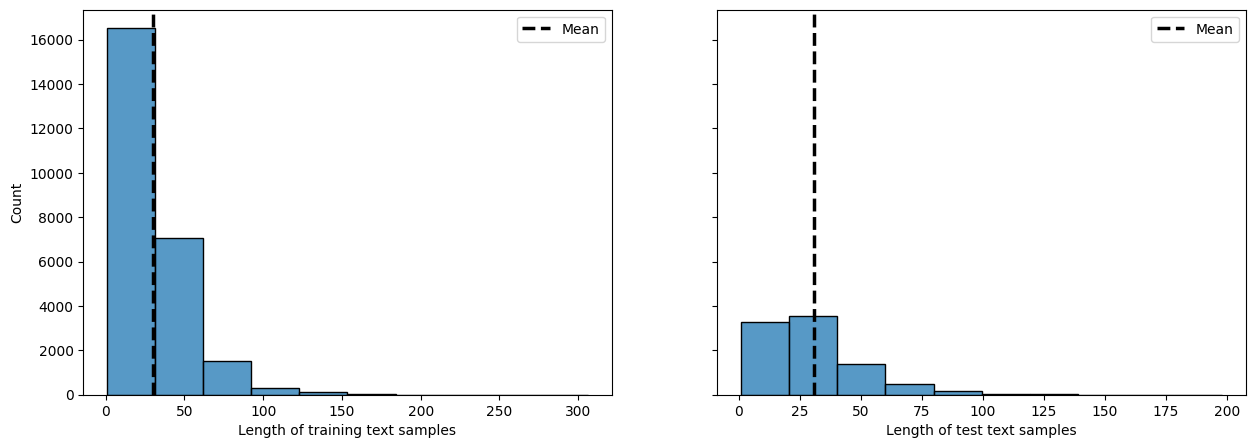

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

train_lengths = train_df["Contents"].str.len()
sns.histplot(ax=axes[0], data=train_lengths, bins=10).set(xlabel="Length of training text samples")
axes[0].axvline(train_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[0].legend()

test_lengths = test_df["Contents"].str.len()
sns.histplot(ax=axes[1], data=test_lengths, bins=10).set(xlabel="Length of test text samples")
axes[1].axvline(test_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[1].legend()


plt.show()

Now, let's find out the number of unique words in both training and test data.

In [ ]:
import re

train_corpus = train_df["Contents"].sum()
test_corpus = test_df["Contents"].sum()

# Remove punctuations
chars_to_ignore = '[<>]'

train_corpus = re.sub(chars_to_ignore, ' ', train_corpus)
train_vocab = set(train_corpus.split())

test_corpus = re.sub(chars_to_ignore, ' ', test_corpus)
test_vocab = set(test_corpus.split())

oov = test_vocab - train_vocab

print("Number of unique words in training data:", len(train_vocab))
print("Number of unique words in test data:", len(test_vocab))
print("Number of out-of-vocabulary (OOV) words:", len(oov))

Number of unique words in training data: 42499
Number of unique words in test data: 15809
Number of out-of-vocabulary (OOV) words: 10881


In [ ]:
# Filtering text samples that contain English alphanumeric values
filtered_train = train_df[lambda x: x["Contents"].str.contains("[A-Za-z0-9]")]

with pd.option_context('display.max_colwidth', 0):
    display(filtered_train.tail(n=10))

,Index,District,Contents,IPA


In [ ]:
bangla_numerals = "[০১২৩৪৫৬৭৮৯]"

filtered_train = train_df[lambda x: x["Contents"].str.contains(bangla_numerals)]
filtered_test = test_df[lambda x: x["Contents"].str.contains(bangla_numerals)]

print("Number of training samples containing Bangla numerals:", len(filtered_train))
print("Number of test samples containing Bangla numerals:", len(filtered_test))

Number of training samples containing Bangla numerals: 2
Number of test samples containing Bangla numerals: 2


## Key Takeaways

- **More than 50%** of the words in the test data are out of vocabulary (OOV).
- **English alphanumeric values** are simply **ignored** in IPA transcription.
- **Almost 30% of the test samples** contain Bengali numerals (সংখ্যা), while such samples are not found in the training set.

# Training

We can frame our problem as a text-to-text generation challenge. Therefore, we can employ any text-to-text models suitable for our task. For this project, we have chosen to use [mT5: A massively multilingual pre-trained text-to-text transformer](https://arxiv.org/abs/2010.11934) and fine-tune it on our dataset. However, feel free to explore and experiment with other text-to-text models that you find suitable. Another alternative is [BanglaT5](https://huggingface.co/csebuetnlp/banglat5) developed by the **BUET CSE NLP Group**.

In [ ]:
# For calculating WER (Word Error Rate)
! pip install jiwer

In [ ]:
# Remove English alphanumeric values
alpha_pat = "[a-zA-z0-9]"

train_df["Contents"] = train_df["Contents"].str.replace(alpha_pat, "", regex=True)
test_df["Contents"] = test_df["Contents"].str.replace(alpha_pat, "", regex=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=3000)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
from datasets import Dataset

ds_train = Dataset.from_pandas(train_df)
ds_eval = Dataset.from_pandas(val_df)

In [ ]:
!pip install --upgrade tensorflow-gpu
!pip install --upgrade cupy-cuda11x

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
        File 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_id = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
data_collator = DataCollatorForSeq2Seq(tokenizer)

2024-02-17 09:18:42.735006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 09:18:42.735140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 09:18:42.870399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def prepare_dataset(sample):
    output = tokenizer(sample["Contents"])
    output["labels"] = tokenizer(sample["IPA"])['input_ids']
    output["length"] = len(output["labels"])
    #print(output)
    return output


ds_train = ds_train.map(prepare_dataset, remove_columns=ds_train.column_names)
ds_eval = ds_eval.map(prepare_dataset, remove_columns=ds_eval.column_names)

  0%|          | 0/22994 [00:00<?, ?ex/s]

  0%|          | 0/2555 [00:00<?, ?ex/s]

In [ ]:
import numpy as np
from datasets import load_metric

wer_metric = load_metric("wer")


def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"wer": result}

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

model_id = "mt5-bangla-text-to-ipa"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_id,
    group_by_length=True,
    length_column_name="length",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    metric_for_best_model="wer",
    greater_is_better=False,
    load_best_model_at_end=True,
    num_train_epochs=1,
    save_steps=4000,
    eval_steps=4000,
    logging_steps=4000,
    learning_rate=3e-4,
    weight_decay=1e-2,
    warmup_steps=2000,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=128,
    push_to_hub=False,
    report_to="none",
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss


Exception ignored in: <function _xla_gc_callback at 0x7ae24e6bab00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
trainer.save_model(model_id)

# Inference

In [ ]:
# Sort by length
index = test_df["Contents"].str.len().sort_values(ascending=False).index
test_df = test_df.reindex(index)

In [ ]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model=model_id, device=0)

In [ ]:
%%time
texts = test_df["Contents"].tolist()
ipas = pipe(texts, max_length=128, batch_size=16)
ipas = [ipa["generated_text"] for ipa in ipas]

In [ ]:
test_df["IPA"] = ipas
test_df = test_df.sort_index()
test_df.head()

In [ ]:
test_df.to_csv("submission.csv", columns=["IPA"])

# What to do next?

Thanks for reading this far. Here is what to do next:

- Explore methods for handling out-of-vocabulary (OOV) words.
- Investigate strategies for handling Bengali numerals.
- Instead of using an encoder-decoder model, try to find ways to solve it simply using an encoder-only model like BERT.